In [1]:
%load_ext autoreload
%autoreload 2
%load_ext wurlitzer

import sys
import json
from ruamel.yaml import YAML
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import lossmaps as lm

from scipy.constants import c as clight

from cpymad.madx import Madx

import xpart as xp
import xtrack as xt
import xobjects as xo
import xdyna as xd
import xcoll as xc
# import xboinc as xb

# context = xo.ContextCpu(omp_num_threads=26)
context = xo.ContextCpu()

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.
['EOS', '5.2.21', '(2020)', 'Developed', 'by', 'the', 'CERN', 'IT', 'storage', 'group']
5.2.21
['5', '2', '21']


In [2]:
coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=149e-6,
                         xdim=0.002, ydim=0.05, side='+', thick=0.0, miscut=0., lattice='strip', jaw_L=0.001, jaw_R=-0.001,
                         align_angle=0.0, _context=context)

# coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bend=0.002/149e-6,
#                          xdim=0.002, ydim=0.05, side='+', thick=0.0, miscut=0., lattice='strip', jaw_L=0.001, jaw_R=-0.001,
#                          align_angle=0.0, _context=context)

# coll = xc.EverestCollimator(length=0.004, material=xc.materials.Silicon, side='+', jaw_L=0.001, jaw_R=-0.001,
#                          _context=context)

num_part = int(10e6)
x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
px_init  = np.random.uniform(low=-50.e-6, high=250.e-6, size=num_part)
y_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
py_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)
part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=4e11, _context=context)
# part._init_random_number_generator()
part_init = part.copy()

io_buffer = xt.new_io_buffer(capacity=int(2e7)) # 4-5 GB of memory
impacts = xt.start_internal_logging(elements=[coll], io_buffer=io_buffer, capacity=io_buffer.capacity)

Compiling ContextCpu kernels...


45308074a5af440ca08707d04897daea.c: In function 'scatter_cry':
45308074a5af440ca08707d04897daea.c:9926:28: warning: unused variable 'x_P' [-Wunused-variable]
 9926 |                     double x_P = -s_P_tmp*sin(tilt_int) + x_P_tmp*cos(tilt_int);
      |                            ^~~
45308074a5af440ca08707d04897daea.c:9925:28: warning: unused variable 's_P' [-Wunused-variable]
 9925 |                     double s_P = s_P_tmp*cos(tilt_int) + x_P_tmp*sin(tilt_int);
      |                            ^~~
45308074a5af440ca08707d04897daea.c:9823:18: warning: unused variable 'cry_spTilt' [-Wunused-variable]
 9823 |     double const cry_spTilt = sin(cry_tilt);
      |                  ^~~~~~~~~~
45308074a5af440ca08707d04897daea.c:9813:12: warning: unused variable 'offset' [-Wunused-variable]
 9813 |     double offset   = everest->coll->offset;
      |            ^~~~~~


Done compiling ContextCpu kernels.


In [19]:
coll.critical_angle

9.637172802036173e-06

In [3]:
%time coll.track(part)

# Sort particles again
part.sort(interleave_lost_particles=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
CPU times: user 7.33 s, sys: 1.55 s, total: 8.88 s
Wall time: 11 s


In [ ]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(15,10))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

# smear_x = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
# smear_y = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
smear_x = 0
smear_y = 0
_ = plt.hist2d(part_init.px[mask]*1.e6+smear_x, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 + smear_y, 500, norm=mpl.colors.LogNorm())
plt.xlim(-30, 180)
plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

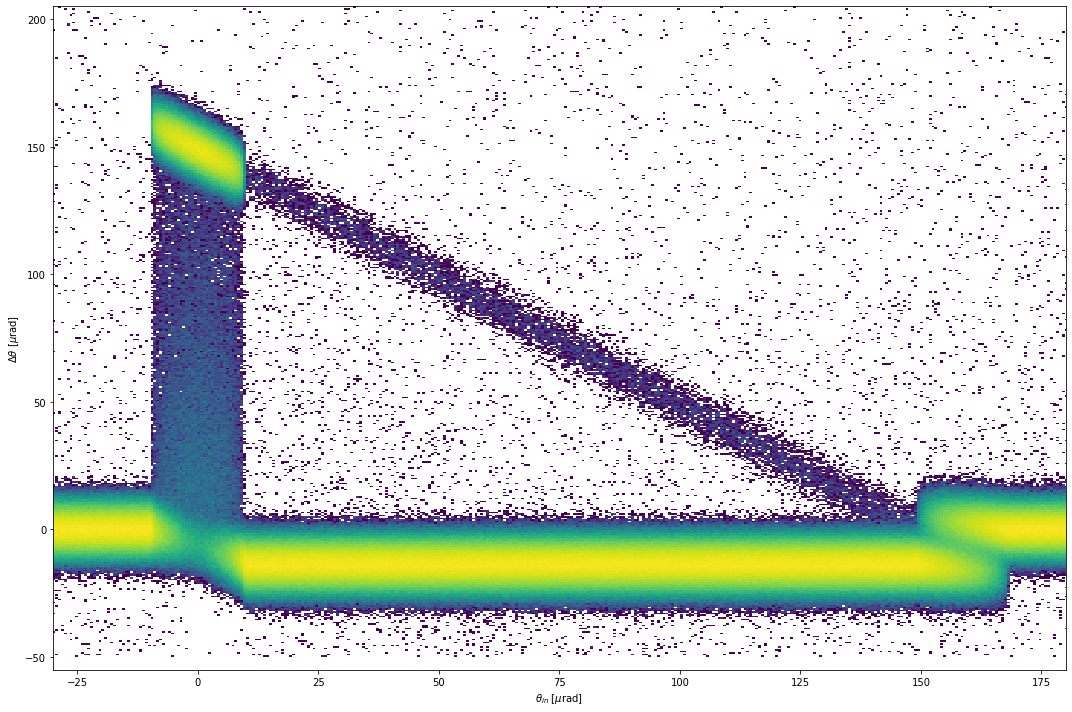

In [4]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(15,10))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

# smear_x = np.random.normal(loc=0., scale=5., size=len(part_init.px[mask]))
# smear_y = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
smear_x = 0
smear_y = 0
_ = plt.hist2d(part_init.px[mask]*1.e6+smear_x, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 + smear_y, 500, norm=mpl.colors.LogNorm())
plt.xlim(-30, 180)
plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

In [4]:
df_imp = impacts.to_pandas()
len(part.state[part.state<0])

41444

In [12]:
df_imp[df_imp.parent_id == 500]

,turn,collimator id,interaction_type,ds,parent_id,parent_x,parent_px,parent_y,parent_py,parent_zeta,...,child_y,child_py,child_zeta,child_delta,child_energy,child_mass,child_charge,child_z,child_a,child_pdgid
1970,0,0,Enter Jaw,0.00000,500,0.000425,0.000064,-0.000838,-0.000004,0.0,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000e+00,-1.000000e+00,-1,-1,-1,-1
1971,0,0,Multiple Coulomb Scattering,0.00086,500,0.000425,0.000064,-0.000838,-0.000004,0.0,...,-0.000838,-0.000008,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
1972,0,0,Volume Capture,0.00000,500,0.000425,0.000065,-0.000838,-0.000008,0.0,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000e+00,-1.000000e+00,-1,-1,-1,-1
1973,0,0,Channeling,0.00114,500,0.000425,0.000065,-0.000838,-0.000008,0.0,...,-0.000838,-0.000008,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
1974,0,0,Exit Jaw,0.00000,500,0.000426,0.000145,-0.000838,-0.000008,0.0,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000e+00,-1.000000e+00,-1,-1,-1,-1


(-2e-05, 1e-05)

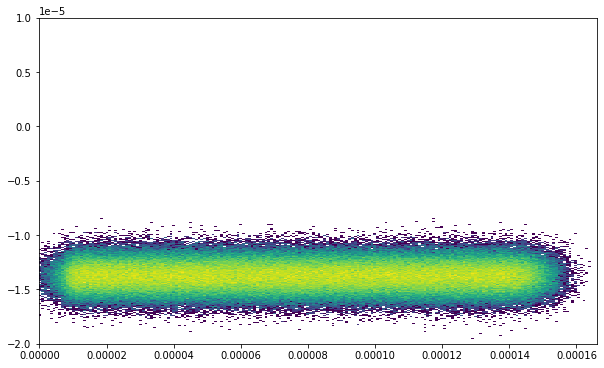

In [6]:
df3 = df_imp[df_imp.interaction_type == 'Volume Reflection']

plt.figure(figsize=(10,6))
_ = plt.hist2d(df3.parent_px, df3.child_px - df3.parent_px, 200, norm=mpl.colors.LogNorm())
plt.ylim(-20.e-6, 10.e-6)

(-0.0015, 0.0015)

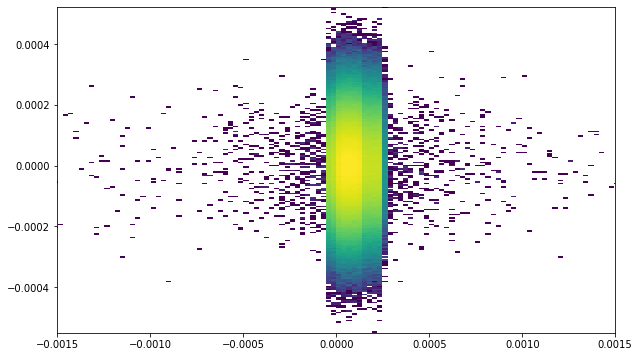

In [7]:
df3 = df_imp[df_imp.interaction_type == 'Multiple Coulomb Scattering']

plt.figure(figsize=(10,6))
_ = plt.hist2d(df3.parent_px, (df3.child_px - df3.parent_px) / np.sqrt(df3.ds), 200, norm=mpl.colors.LogNorm())
plt.xlim(-1.5e-3, 1.5e-3)
# plt.ylim(-30.e-6, 30.e-6)

In [18]:
df = impacts.interactions_per_collimator()
# df.loc[576926] = []
result = [inters for inters in df if inters[-1] == 'CH']
print(len(result))
result

219775


[['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['MCS', 'VC', 'CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['MCS', 'VC', 'CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['MCS', 'VC', 'CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH'],
 ['CH']

In [6]:
result = np.unique(df.values, return_counts=True)
print(result[1].sum())
for inter, n in zip(result[0], result[1]):
    print(inter, n)

1000000
['AMVR'] 31667
['AMVR', 'A'] 138
['AMVR', 'PN', 'AMVR'] 1
['AMVR', 'PN', 'MCS'] 47
['AMVR', 'PN', 'MCS', 'VR', 'MCS'] 9
['AMVR', 'PN', 'VRAM', 'MCS'] 2
['AMVR', 'PP', 'MCS'] 12
['AMVR', 'PP', 'MCS', 'VR', 'MCS'] 1
['AMVR', 'SD', 'MCS'] 9
['AMVR', 'SD', 'MCS', 'VR', 'MCS'] 1
['CH'] 42228
['CH', 'A'] 54
['CH', 'DCH', 'AMVR'] 2
['CH', 'DCH', 'MCS'] 2251
['CH', 'DCH', 'MCS', 'A'] 7
['CH', 'DCH', 'MCS', 'PN', 'MCS'] 1
['CH', 'DCH', 'MCS', 'VC', 'CH'] 5
['CH', 'DCH', 'MCS', 'VC', 'CH', 'DCH', 'MCS', 'VR', 'MCS'] 1
['CH', 'DCH', 'MCS', 'VR', 'MCS'] 2291
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A'] 10
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'PN', 'MCS'] 1
['CH', 'DCH', 'VRAM', 'MCS'] 19
['CH', 'PN', 'AMVR'] 2
['CH', 'PN', 'MCS'] 17
['CH', 'PN', 'MCS', 'VR', 'MCS'] 1
['CH', 'PP', 'MCS'] 6
['CH', 'PP', 'MCS', 'VR', 'MCS'] 1
['CH', 'RU', 'MCS'] 1
['CH', 'SD', 'MCS'] 1
['CH', 'SD', 'MCS', 'VR', 'MCS'] 2
['CH', 'SD', 'VRAM', 'MCS'] 1
['MCS'] 404745
['MCS', 'A'] 2831
['MCS', 'PN', 'AMVR'] 15
['MCS', 'PN

In [4]:
mask1 = ['PP' in proc or 'PN' in proc or 'SD' in proc or 'RU' in proc or 'A' in proc for proc in df.sort_index().values]
mask1 = [proc != ['DRVI', 'VR', 'VRAM', 'MCS'] for proc in df.sort_index().values]
mask2 = ['AMVR' in proc for proc in df.sort_index().values]

NameError: name 'df' is not defined

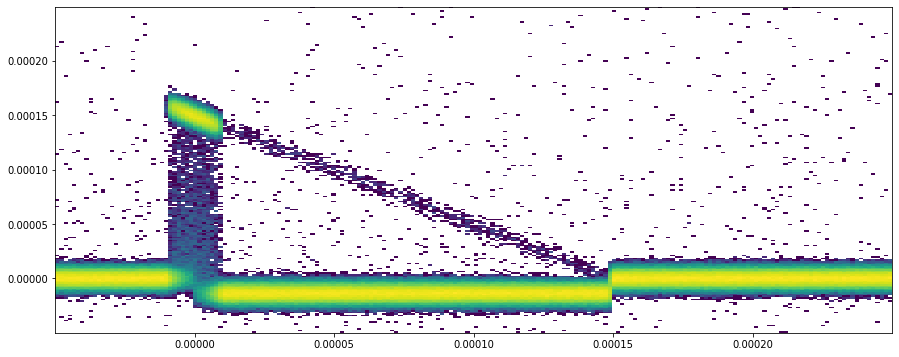

In [4]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 250.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2

plt.figure(figsize=(15,6))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

smear_x = np.random.normal(loc=0., scale=2.8e-6, size=len(part_init.px[mask]))
smear_y = np.random.normal(loc=0., scale=2.8e-6, size=len(part_init.px[mask]))
smear_x = 0
smear_y = 0
_ = plt.hist2d(part_init.px[mask]+smear_x, part.px[mask] - part_init.px[mask] + smear_y, 200, norm=mpl.colors.LogNorm())
# plt.ylim(-50.e-6, 50.e-6)
# plt.xlim(130.e-6, 170.e-6)
# plt.ylim(-50.e-6, 20.e-6)

In [81]:
short_inter = []
for inter in result[0]:
    short_inter += [ inter[:2] ]
np.unique(short_inter)

/home/fvanderv/miniconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


array([list(['CH']), list(['CH', 'A']), list(['CH', 'DCH']),
       list(['CH', 'PN']), list(['CH', 'PP']), list(['CH', 'RU']),
       list(['CH', 'SD']), list(['MCS']), list(['MCS', 'A']),
       list(['MCS', 'PN']), list(['MCS', 'PP']), list(['MCS', 'RU']),
       list(['MCS', 'SD']), list(['VRAM', 'MCS']), list(['VRCH', 'MCS'])],
      dtype=object)

In [82]:
Nc = 0
Nd = 0
Nca = 0
Ncn = 0
for inter, n in zip(result[0], result[1]):
    if inter[0] == 'CH':
        Nc += n
        if len(inter) >1:
            if inter[1] == 'DCH':
                Nd += n
            elif inter[1] == 'A':
                Nca += n
            elif inter[1] == 'PN' or inter[1] == 'PP' or inter[1] == 'RU' or inter[1] == 'SD':
                Ncn += n
print(f"Nc: {Nc/1e6:.1%}, of which:  Nca: {Nca/Nc:.1%},  Nd: {Nd/Nc:.1%},  Ncn: {Ncn/Nc:.1%}")

Nc: 57.0%, of which:  Nca: 0.1%,  Nd: 9.7%,  Ncn: 0.1%


4.013864455657653e-09


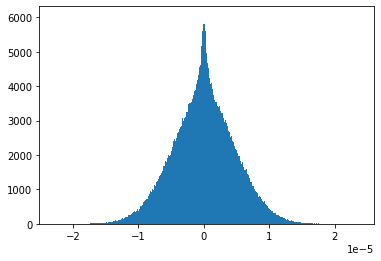

In [93]:
df2 = impacts.to_pandas()
df3 = df2[df2.interaction_type == 'Multiple Coulomb Scattering']
print(np.mean(df3['parent_px'] - df3['child_px']))

_ = plt.hist(df3['parent_px'] - df3['child_px'], 500)

In [11]:
df2 = impacts.to_pandas()
df2[df2['parent_id'] == 999996]

,turn,collimator id,interaction_type,ds,parent id,parent x,parent px,parent y,parent py,parent zeta,...,child y,child py,child zeta,child delta,child energy,child mass,child charge,child z,child a,child pdgid
5314262,0,0,Enter Jaw,0.000000,999996,0.000490,0.000007,-0.001591,0.000002,0.0,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000e+00,-1.000000e+00,-1,-1,-1,-1
5314263,0,0,Channeling,0.044492,999996,0.000490,0.000007,-0.001591,0.000002,0.0,...,-0.001591,0.000002,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
5314264,0,0,Dechanneling,0.000000,999996,0.000738,0.011131,-0.001591,0.000002,0.0,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000e+00,-1.000000e+00,-1,-1,-1,-1
5314265,0,0,Volume Reflection Trans MCS,0.000000,999996,0.000738,0.011131,-0.001591,0.000002,0.0,...,-0.001591,0.000002,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
5314266,0,0,Multiple Coulomb Scattering,0.000005,999996,0.000738,0.039851,-0.001591,0.000002,0.0,...,-0.001591,0.000002,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
5314267,0,0,Volume Reflection,0.000000,999996,0.000738,0.039851,-0.001591,0.000002,0.0,...,-0.001591,0.000002,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
5314268,0,0,Volume Reflection Trans MCS,0.000000,999996,0.000738,0.039843,-0.001591,0.000002,0.0,...,-0.001591,0.000002,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
5314269,0,0,Multiple Coulomb Scattering,0.114772,999996,0.000738,0.047326,-0.001591,0.000002,0.0,...,-0.001591,0.000026,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
5314270,0,0,Volume Reflection,0.000000,999996,0.006170,0.047360,-0.001591,0.000026,0.0,...,-0.001591,0.000026,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
5314271,0,0,Volume Reflection Trans MCS,0.000000,999996,0.006170,0.047355,-0.001591,0.000026,0.0,...,-0.001591,0.000026,0.0,0.0,4.000011e+11,9.382721e+08,1,-1,-1,-1
